### Imports

In [5]:
%load_ext autoreload
%autoreload 2

import torch
from torch_geometric.loader import DataLoader
from data_utils import *
from tqdm import tqdm

import networkx as nx
import torch_geometric.utils as pyg_utils

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import gaussian_kde

import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS

from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

from graph_vae.vae import GraphVAE

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Model and Dataset

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# uncomment one of the following lines depending on which model you want to use
checkpoint = "./checkpoints/graph_vae_20240531_081109.pt"  # LUMO without latent split
# checkpoint = "./checkpoints/graph_vae_20240531_093644.pt"  # LUMO with latent split
# checkpoint = "./checkpoints/graph_vae_20240531_052030.pt"  # HOMO wihtout latent split
# checkpoint = "./checkpoints/graph_vae_20240531_064545.pt"  # HOMO with latent split

model = GraphVAE.from_pretrained(checkpoint_path=checkpoint).to(device)
model.eval()

print(f"Loaded model trained on properties: {model.properties}")

include_hydrogen = False
prop_norm_df = create_or_load_property_norm_df()
# create dataset and dataloaders
dataset = create_qm9_graph_vae_dataset(
    device=device, 
    include_hydrogen=include_hydrogen,
    refresh_data_cache=False,
    properties=model.properties,
    prop_norm_df=prop_norm_df
)

batch_size = 1024
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# load training data smiles with properties to get the true properties of generated molecules
full_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)
dataset_smiles_with_prop = dict()
for batch in tqdm(full_loader, desc="Converting dataset graphs to SMILES"):
    for sample_index in range(len(batch)):
        sample = batch[sample_index]
        mol = graph_to_mol(data=sample, includes_h=include_hydrogen, validate=False)
        dataset_smiles_with_prop[Chem.MolToSmiles(mol)] = model.denormalize_properties(sample.y)

Loaded model trained on properties: ['lumo']


Converting dataset graphs to SMILES: 100%|██████████| 126/126 [03:43<00:00,  1.77s/it]


### Sample Posterior

In [7]:
def sample_posterior(model: GraphVAE, target_property_value: float):
    y_target = torch.tensor(data=[target_property_value], device=device).unsqueeze(0)
    y_target_norm = model.normalize_properties(y=y_target)

    def pyro_model(y_obs):
        z = pyro.sample("z", dist.Normal(torch.zeros(model.property_z_size, device=device), torch.ones(model.property_z_size, device=device))).unsqueeze(0)
        y_mu, y_sigma = model.predict_properties(z)
        with pyro.plate("data"):
            pyro.sample("obs", dist.Normal(y_mu, y_sigma), obs=y_obs)


    # Define the MCMC kernel, here using NUTS, which is good for continuous parameters
    nuts_kernel = NUTS(pyro_model)

    sample_count = 1000

    # Run the MCMC sampler
    mcmc = MCMC(nuts_kernel, num_samples=sample_count, warmup_steps=500)
    mcmc.run(y_obs=y_target_norm)  # replace with your actual observed data
    posterior_samples = mcmc.get_samples()["z"]

    return posterior_samples


posterior_samples = sample_posterior(model=model, target_property_value=2.0)

In [11]:
posterior_samples.shape

torch.Size([500, 128])

In [ ]:
# TODO: KDE latent dim


# ALL in a single plot with dataset KDE
# TODO: KDE predicted properties mean
# TODO: KDE predicted properties sampled
# TODO: KDE predicted properties mean re-encoded (include valid and invalid)
# TODO: KDE predicted properties sampled re-encoded

### Outdated

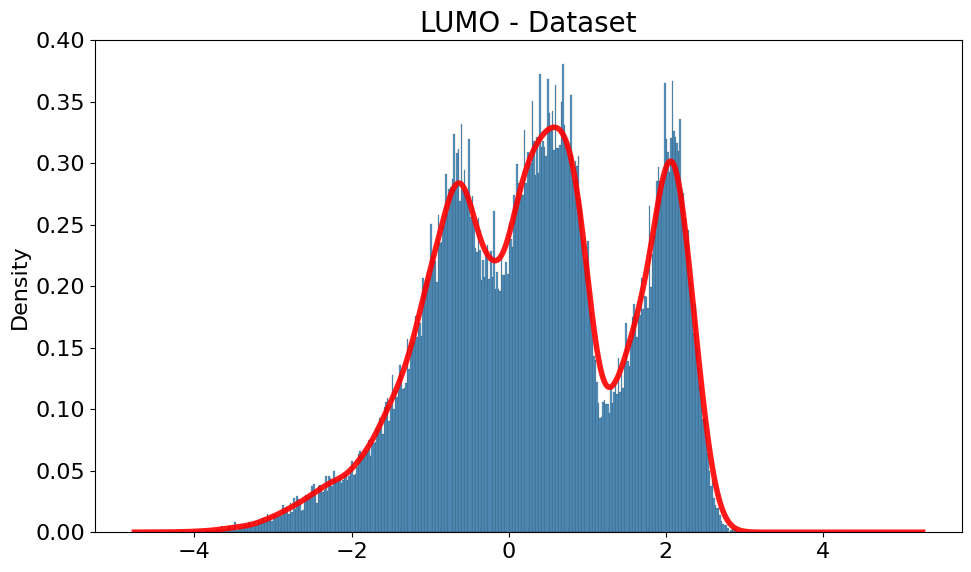

In [4]:
y_list = [y for y in dataset_smiles_with_prop.values()]
y = torch.cat(y_list, dim=0)
num_properties = len(model.properties)

fig, axes = plt.subplots(nrows=1, ncols=num_properties, figsize=(10 * num_properties, 6))
if num_properties == 1:
    axes = [axes]

x_d_list = []
density_dataset_list = []
for i, property in enumerate(model.properties):
    data = y[:, i].cpu().numpy()
    kde = gaussian_kde(data)
    x_d = np.linspace(np.min(data), np.max(data), 1000)
    x_d_list.append(x_d)
    density = kde(x_d)
    density_dataset_list.append(density)
    
    sns.histplot(data, bins=512, kde=False, stat='density', ax=axes[i])
    axes[i].plot(x_d, density, color='red', linewidth=4, alpha=0.9)
    axes[i].set_title(f"{property.upper()} - Dataset", fontsize=20)

plt.tight_layout()
plt.show()

In [ ]:
# TODO: create plot property histogram function

Sample: 100%|██████████| 2000/2000 [03:06, 10.71it/s, step size=2.65e-01, acc. prob=0.864]


In [10]:
class GeneratedDataset(Dataset):
    def __init__(self, data_list):
        super().__init__()
        self.data_list = data_list

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        return self.data_list[idx]


dataset_mol_count = 0
y_sample_list = []
valid_count = 0
data_list = []

# decode posterior samples
iteration_count = 1
if model.latent_dim != model.property_z_size:
    iteration_count = 4
else:
    z = posterior_samples["z"]

for _ in range(iteration_count):

    if model.latent_dim != model.property_z_size:
        z_prop = posterior_samples["z"]
        random_part = torch.randn(z_prop.shape[0], model.latent_dim - model.property_z_size, device=device)
        z = torch.cat((z_prop, random_part), dim=1)
    else:
        z = posterior_samples["z"]

    x = model.decode(z=z)

    for i in tqdm(range(sample_count)):
        sample_matrices = (x[0][i:i+1], x[1][i:i+1], x[2][i:i+1])

        for _ in range(32):
            sample_graph = model.output_to_graph(x=sample_matrices, stochastic=True)

            # Check if the generated graph is connected
            if not nx.is_connected(pyg_utils.to_networkx(sample_graph, to_undirected=True)):
                continue

            try:
                mol = graph_to_mol(data=sample_graph, includes_h=include_hydrogen, validate=True)
            except Exception as e:
                # Molecule is invalid; try to decode again
                continue

            # Molecule is valid
            if mol:
                data_list.append(sample_graph)

                smiles = Chem.MolToSmiles(mol)
                if smiles in dataset_smiles_with_prop:
                    y_sample_list.append(dataset_smiles_with_prop[smiles])
                    dataset_mol_count += 1
                
generated_dataset = GeneratedDataset(data_list=data_list)
print(dataset_mol_count)

  0%|          | 0/1500 [00:00<?, ?it/s]

100%|██████████| 1500/1500 [01:52<00:00, 13.38it/s]

44332


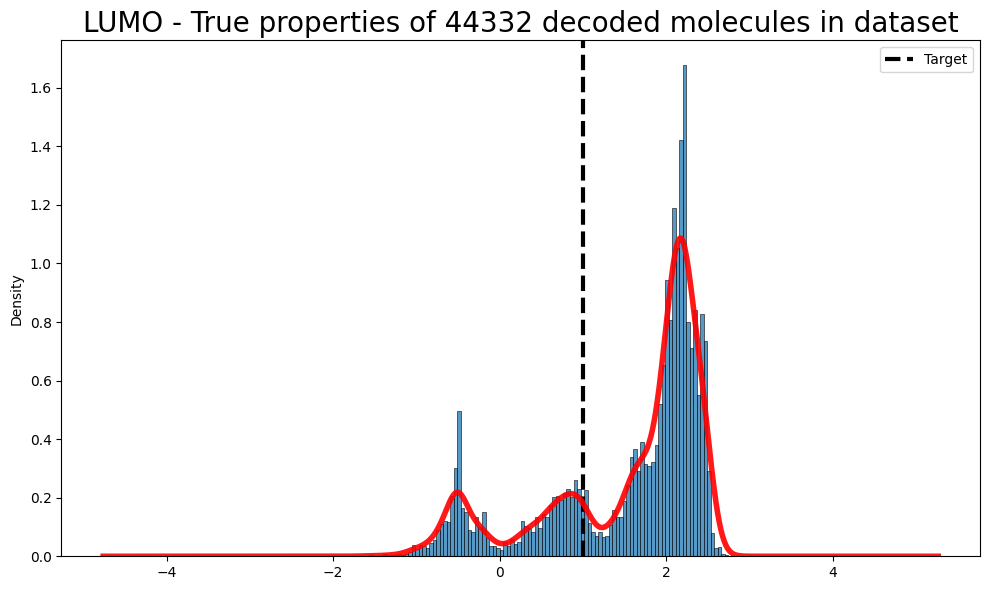

In [11]:
y_samples = torch.cat(y_sample_list, dim=0)
num_properties = len(model.properties)

fig, axes = plt.subplots(nrows=1, ncols=num_properties, figsize=(10 * num_properties, 6))
if num_properties == 1:
    axes = [axes]

density_sampled_list = []
for i, property in enumerate(model.properties):
    data = y_samples[:, i].cpu().numpy()
    kde = gaussian_kde(data)
    x_d = x_d_list[i]
    density = kde(x_d)
    density_sampled_list.append(density)
    
    sns.histplot(data, bins=128, kde=False, stat='density', ax=axes[i])
    axes[i].axvline(y_target[:, i].cpu().numpy(), color='k', linestyle='dashed', linewidth=3, label="Target")
    axes[i].plot(x_d, density, color='red', linewidth=4, alpha=0.9)
    axes[i].set_title(f"{property.upper()} - True properties of {dataset_mol_count} decoded molecules in dataset", fontsize=20)
    axes[i].legend()

plt.tight_layout()
plt.show()

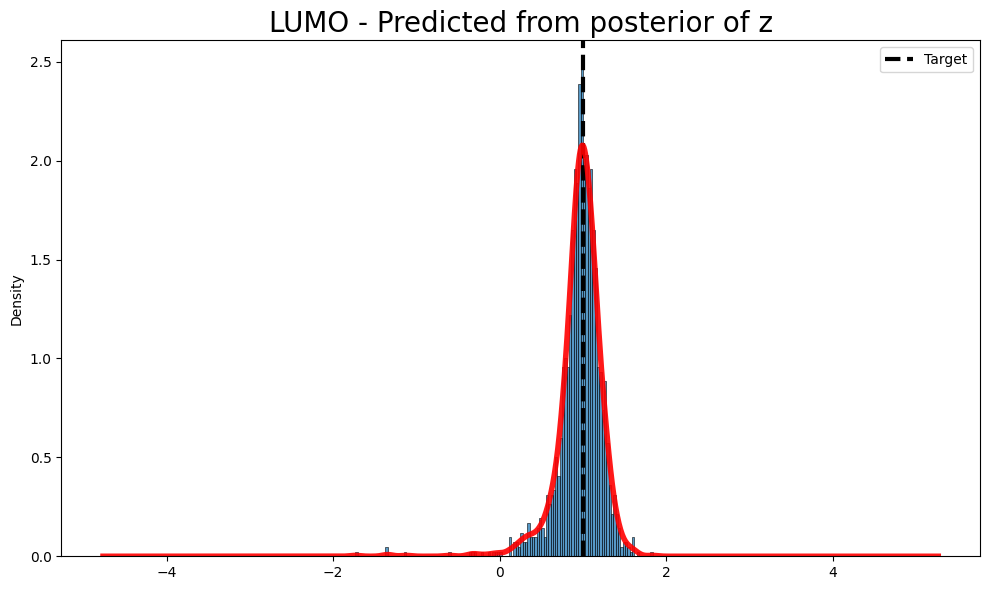

In [13]:
# plot properties predicted from posterior z
y_predicted = model.denormalize_properties(model.predict_properties(posterior_samples["z"])[0].detach())
num_properties = len(model.properties)

fig, axes = plt.subplots(nrows=1, ncols=num_properties, figsize=(10 * num_properties, 6))
if num_properties == 1:
    axes = [axes]

density_sampled_list = []
for i, property in enumerate(model.properties):
    data = y_predicted[:, i].cpu().numpy()
    kde = gaussian_kde(data)
    x_d = x_d_list[i]
    density = kde(x_d)
    density_sampled_list.append(density)
    
    sns.histplot(data, bins=128, kde=False, stat='density', ax=axes[i])
    axes[i].axvline(y_target[:, i].cpu().numpy(), color='k', linestyle='dashed', linewidth=3, label="Target")
    axes[i].plot(x_d, density, color='red', linewidth=4, alpha=0.9)
    axes[i].set_title(f"{property.upper()} - Predicted from posterior of z", fontsize=20)
    axes[i].legend()

plt.tight_layout()
plt.show()

100%|██████████| 112/112 [00:04<00:00, 24.69it/s]


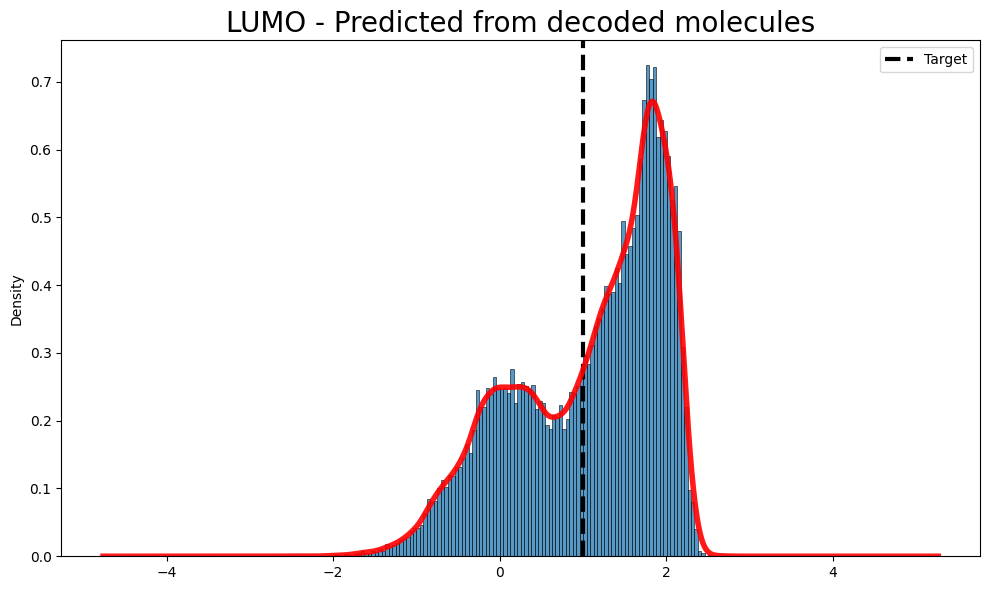

In [14]:
# predict properties of decoded molecules

generated_loader = DataLoader(dataset=generated_dataset, batch_size=1024)
y_generated_list = []
for batch in tqdm(generated_loader):
    z = model.encode_mean(batch)
    z = model.z_to_property_z(z)
    y = model.denormalize_properties(model.predict_properties(z)[0].detach())
    y_generated_list.append(y)

y_generated = torch.cat(y_generated_list, dim=0)

num_properties = len(model.properties)

fig, axes = plt.subplots(nrows=1, ncols=num_properties, figsize=(10 * num_properties, 6))
if num_properties == 1:
    axes = [axes]

density_sampled_list = []
for i, property in enumerate(model.properties):
    data = y_generated[:, i].cpu().numpy()
    kde = gaussian_kde(data)
    x_d = x_d_list[i]
    density = kde(x_d)
    density_sampled_list.append(density)
    
    sns.histplot(data, bins=128, kde=False, stat='density', ax=axes[i])
    axes[i].axvline(y_target[:, i].cpu().numpy(), color='k', linestyle='dashed', linewidth=3, label="Target")
    axes[i].plot(x_d, density, color='red', linewidth=4, alpha=0.9)
    axes[i].set_title(f"{property.upper()} - Predicted from decoded molecules", fontsize=20)
    axes[i].legend()

plt.tight_layout()
plt.show()